# Brazilian Partition

Using Mixed Integer Programming to partite Brazil in different regions with similar population. The important detail is to keep these regions connected, i.e., contiguous. We'll firstly present a more simple, yet incomplete, model and then work over it.

In [1]:
from mip import *

import re
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import itertools

Using Python-MIP package version 1.6.7


### DATA

We will again use IBGE (Brazilian Institute of Geography and Statistics) data. Source links are available in previous experiments.

Map data.

In [6]:
gdf = gpd.read_file("Data/br_municipios_2018/BRMUE250GC_SIR.shp")
gdf = gdf.drop(gdf[(gdf["CD_GEOCMU"] == "4300001") | (gdf["CD_GEOCMU"] == "4300002")].index)
gdf = gdf.drop(gdf[(gdf["CD_GEOCMU"] == "2605459") | (gdf["CD_GEOCMU"] == "3520400")].index)
gdf = gdf.set_index("CD_GEOCMU")
gdf.head()

,NM_MUNICIP,geometry
CD_GEOCMU,,
5200050,ABADIA DE GOIÁS,"POLYGON ((-49.44440 -16.71747, -49.44435 -16.7..."
3100104,ABADIA DOS DOURADOS,"POLYGON ((-47.43840 -18.16570, -47.43588 -18.1..."
5200100,ABADIÂNIA,"POLYGON ((-48.84178 -16.00488, -48.79639 -16.0..."
3100203,ABAETÉ,"POLYGON ((-45.16777 -18.89073, -45.16719 -18.8..."
1500107,ABAETETUBA,"POLYGON ((-48.83139 -1.56352, -48.82910 -1.571..."


In [109]:
gdf_est = gpd.read_file("Data/br_estados_2018/BRUFE250GC_SIR.shp")
gdf_est = gdf_est.drop(gdf_est[(gdf_est["CD_GEOCUF"] == "53")].index)
gdf_est = gdf_est.set_index("NM_ESTADO")
gdf_est.head()

,NM_REGIAO,CD_GEOCUF,geometry
NM_ESTADO,,,
ACRE,NORTE,12,"POLYGON ((-73.18253 -7.33550, -73.05413 -7.381..."
ALAGOAS,NORDESTE,27,"POLYGON ((-35.46753 -8.81744, -35.46659 -8.817..."
AMAPÁ,NORTE,16,"MULTIPOLYGON (((-50.18123 1.90099, -50.17688 1..."
AMAZONAS,NORTE,13,"POLYGON ((-67.32609 2.02971, -67.31682 2.00125..."
BAHIA,NORDESTE,29,"MULTIPOLYGON (((-38.65484 -18.04242, -38.65819..."


Population data

In [8]:
xls = pd.ExcelFile('Data/estimativa_dou_2019.ods', engine="odf")

In [31]:
pop = pd.read_excel(xls, 1, header=1).loc[:5569]
pop["CD_GEOCMU"] = pop[['COD. UF', 'COD. MUNIC']].apply(lambda x: str(int(x[0])) + str(int(x[1])).zfill(5), axis=1)

pop = pop[["CD_GEOCMU", "POPULAÇÃO ESTIMADA"]]
pop.columns = ["CD_GEOCMU", "POP"]

pop["POP"] = pop["POP"].apply(lambda x: int(re.sub(r'\([^)]*\)', '', str(x)).replace(".","")))
pop = pop.drop(pop[(pop["CD_GEOCMU"] == "2605459") | (pop["CD_GEOCMU"] == "3520400")].index)

pop = pop.set_index("CD_GEOCMU")
pop = pop.reindex(gdf.index)

pop.head()

,POP
CD_GEOCMU,
5200050,8773
3100104,6989
5200100,20042
3100203,23237
1500107,157698


In [115]:
pop_est = pd.read_excel(xls, 0, header=1).loc[1:32][["BRASIL E UNIDADES DA FEDERAÇÃO", "POPULAÇÃO ESTIMADA"]]
pop_est.columns = ["NM_ESTADO", "POP"]
pop_est = pop_est.drop(pop_est[(pop_est["NM_ESTADO"] == "Distrito Federal")].index)
pop_est = pop_est[~pop_est.NM_ESTADO.str.contains('Região')]
pop_est["POP"] = pop_est["POP"].apply(lambda x: int(re.sub(r'\([^)]*\)', '', str(x)).replace(".","")))
pop_est["NM_ESTADO"] = pop_est["NM_ESTADO"].apply(lambda x: x.upper())
pop_est = pop_est.set_index("NM_ESTADO")
pop_est = pop_est.reindex(gdf_est.index)
pop_est.head()

,POP
NM_ESTADO,
ACRE,881935
ALAGOAS,3337357
AMAPÁ,845731
AMAZONAS,4144597
BAHIA,14873064


In [116]:
gdf_est = gdf_est.set_index("CD_GEOCUF")
pop_est.index = gdf_est.index

Graph data

In [107]:
g = nx.read_gml("Data/Brazil.gml")
print(nx.info(g), "\n")
g_est = nx.read_gml("Data/Brazil_estado.gml")
print(nx.info(g_est))

Name: 
Type: Graph
Number of nodes: 5568
Number of edges: 16050
Average degree:   5.7651 

Name: 
Type: Graph
Number of nodes: 26
Number of edges: 49
Average degree:   3.7692


Here we are just creating some constants for our models

In [183]:
vals = pop["POP"].map(int).values.tolist()
pop_total = sum(vals)
cities = len(vals)
idx = gdf.index

In [53]:
vals_est = pop_est["POP"].map(int).values.tolist()
pop_total_est = sum(vals_est)
estados = len(vals_est)
idx_est = gdf_est.index

### A SINGLE CONNECTED REGION

In this first model, we will search for a connected region with half of the total population. Modelling connectivity is not trivial. We use the approach by [Bistra Dilkina and Carla P. Gomes](https://www.cc.gatech.edu/~bdilkina/papers/CPAIOR2010_dilkina.pdf), with a polynomial number of restrictions and variables. The idea is to use flow from a new created vertice to this subgraph. I hope the comments make it clearer. We also have to define a *seed*, a municipality that has to be part of the region. It is the city of São Paulo by default.

In [196]:
def set_connected(seed=None):
    edges = list(g.edges)
    A = edges + [e[::-1] for e in edges]
    N = g.number_of_nodes()
    
    if seed == None:
        seed = idx.get_loc("3550308")
    
    m = Model()
    
    # Wether or not the city is in the region
    x = [m.add_var(var_type=BINARY) for j in range(cities)]
    x0 = m.add_var(ub=N)
    
    # Flow of each edge
    y = [m.add_var() for e in A]
    y0 = m.add_var(ub=N)
    
    abs_diff = m.add_var()

    # Seed is in the region
    m += x[seed] == 1
    
    # Residual + injected = N
    m += x0 + y0 == N

    # If there is flow in this edge, then the node is in the region
    for e in range(len(A)):
        m += y[e] <= N*x[idx.get_loc(A[e][1])]

    # Flow in equals flow out plus consumed
    for j in [k for k in range(cities) if k != seed]:
        m += xsum(y[e] for e in range(len(A)) if idx.get_loc(A[e][1])==j)\
            == x[j] + xsum(y[e] for e in range(len(A)) if idx.get_loc(A[e][0])==j) 
    
    # Same for seed
    m += xsum(y[e] for e in range(len(A))if idx.get_loc(A[e][1])==seed) + y0\
        == 1 + xsum(y[e] for e in range(len(A)) if idx.get_loc(A[e][0])==seed)

    # Absorbed = injected
    m += xsum(x[j] for j in range(cities)) == y0

    # Absolute difference to the expected value
    expected = int(round(pop_total / 2,0))
    m += xsum(x[j]*vals[j] for j in range(cities)) - expected <= abs_diff
    m += expected - xsum(x[j]*vals[j] for j in range(cities)) <= abs_diff

    m.objective = abs_diff
    
    print("Model set.")
    return m

### CONNECTED REGIONS

We enhance the model by adding more regions. This is very costly, the municipal map is too large for it. That's why we used the states instead (very fast to run). Note that we need to define multiple seeds, one for every region.

In [193]:
def set_regions(n=2, seed=None):
    edges = list(g_est.edges)
    A = edges + [e[::-1] for e in edges]
    N = g_est.number_of_nodes()
    
    if seed == None and n < 5:
        seed = [idx_est.get_loc(x) for x in ["52", "43", "24", "31"]][:n]
    
    m = Model()
    
    # Wether or not the city is in the region i
    x = [[m.add_var(var_type=BINARY) for j in range(estados)] for i in range(n)]
    x0 = [m.add_var(ub=N) for i in range(n)]
    
    # Flow of each edge in region i
    y = [[m.add_var() for e in A] for i in range(n)]
    y0 = [m.add_var(ub=N) for i in range(n)]
    
    abs_diff = [m.add_var() for i in range(n)]

    # Every state has one, and only one, region
    for j in range(estados):
        m += xsum(x[i][j] for i in range(n)) == 1
    
    for i in range(n):
        # This seed is in this region
        m += x[i][seed[i]] == 1
        
        # Residual + injected = N
        m += x0[i] + y0[i] == N
        
        # If there is flow in this edge in this region, then the node is in this region
        for e in range(len(A)):
            m += y[i][e] <= N*x[i][idx_est.get_loc(A[e][1])]
            
        # Flow in equals flow out plus consumed
        for j in [k for k in range(estados) if k != seed[i]]:
            m += xsum(y[i][e] for e in range(len(A)) if idx_est.get_loc(A[e][1])==j)\
                == x[i][j] + xsum(y[i][e] for e in range(len(A)) if idx_est.get_loc(A[e][0])==j)
            
        # Same for seed
        m += xsum(y[i][e] for e in range(len(A)) if idx_est.get_loc(A[e][1])==seed[i]) + y0[i]\
                == 1 + xsum(y[i][e] for e in range(len(A)) if idx_est.get_loc(A[e][0])==seed[i]) 
        
        # Absorbed = injected
        m += xsum(x[i][j] for j in range(estados)) == y0[i]
    
    
    # Absolute difference to the expected value
    expected = int(round(pop_total_est / n,0))
    for i in range(n):
        m += xsum(x[i][j]*vals_est[j] for j in range(estados)) - expected <= abs_diff[i]
        m += expected - xsum(x[i][j]*vals_est[j] for j in range(estados)) <= abs_diff[i]

    m.objective = xsum(abs_diff)
    
    print("Model set.")
    return m

### AUXILIARY FUNCTIONS

The following function calls the optimizer.

In [187]:
def solve(m, verbose=True):
    m.max_gap = 0.01
    status = m.optimize()
    if verbose:
        if status == OptimizationStatus.OPTIMAL:
            print('optimal solution cost {} found'.format(m.objective_value))
        elif status == OptimizationStatus.FEASIBLE:
            print('sol.cost {} found, best possible: {}'.format(m.objective_value, m.objective_bound))
        elif status == OptimizationStatus.NO_SOLUTION_FOUND:
            print('no feasible solution found, lower bound is: {}'.format(m.objective_bound))
        elif status == OptimizationStatus.INFEASIBLE:
            print('INFEASIBLE'.format(m.objective_bound))
    return m

Plot function.

In [226]:
def plot_map(gdf, colors):
    gdf["colors"] = colors
    
    fig, ax = plt.subplots(1, 1)
    ax.axis('off')
    fig.set_size_inches(15, 15)
    gdf.plot(column="colors", categorical=True, legend=True, ax=ax, cmap='Accent')
    plt.show()

Get the color numbers from the simplest model.

In [185]:
def get_colors_connected(m):
    dum = list()
    lw = 0
    up = cities

    return [j.x for j in m.vars[lw:up]]

Get the color numbers from the advanced model.

In [129]:
def get_colors_regions(m, n=2):
    dum = list()
    lw = 0
    up = estados
    
    for i in range(n):
        dum.append([j.x for j in m.vars[lw:up]])
        lw += estados
        up += estados
    
    a = np.transpose(np.array(dum))
    return [np.where(r==1)[0][0] for r in a]

Get the populations for the regions

In [207]:
def get_pop(colors, vals):
    pop = {i:0 for i in range(max(colors)+1)}
    for i in range(len(colors)):
        pop[colors[i]] += vals[i]
    
    return pop

### RESULTS

First model, using the default seed (85 minutes). Both regions have the EXACT same population.

In [197]:
m1 = set_connected()
m1 = solve(m1)

Model set.
optimal solution cost 0.0 found


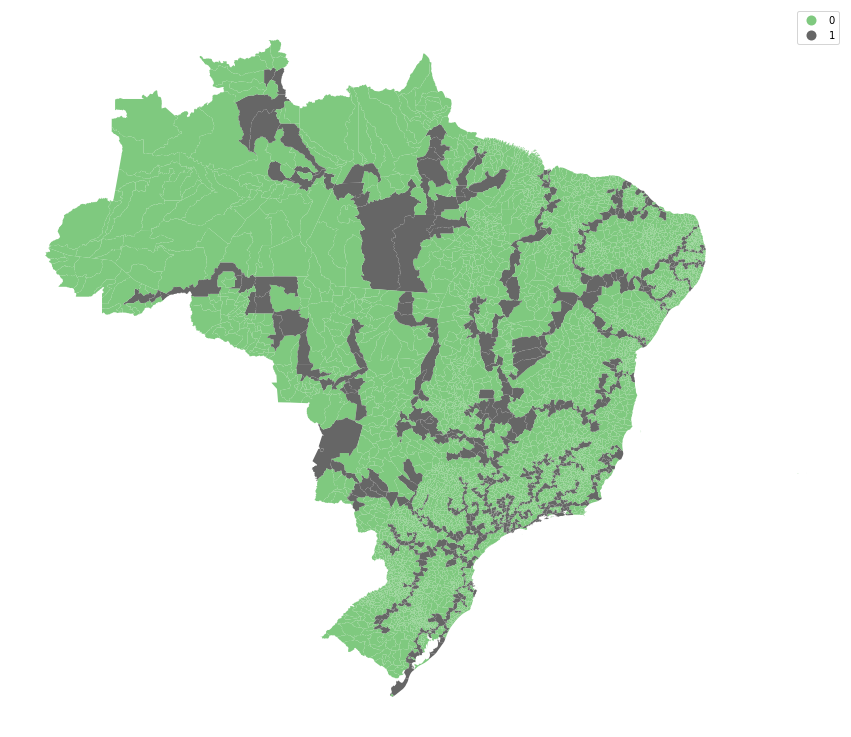

In [227]:
cols = get_colors_connected(m1)
plot_map(gdf, cols)

We can then run the second model. We'll be using 5 regions (a couple of seconds). The legend has the populations of each region.

In [194]:
m2 = set_regions(5, [idx_est.get_loc(x) for x in ["14", "33", "35", "52", "24"]])
m2 = solve(m2)

Model set.
optimal solution cost 9352248.0 found


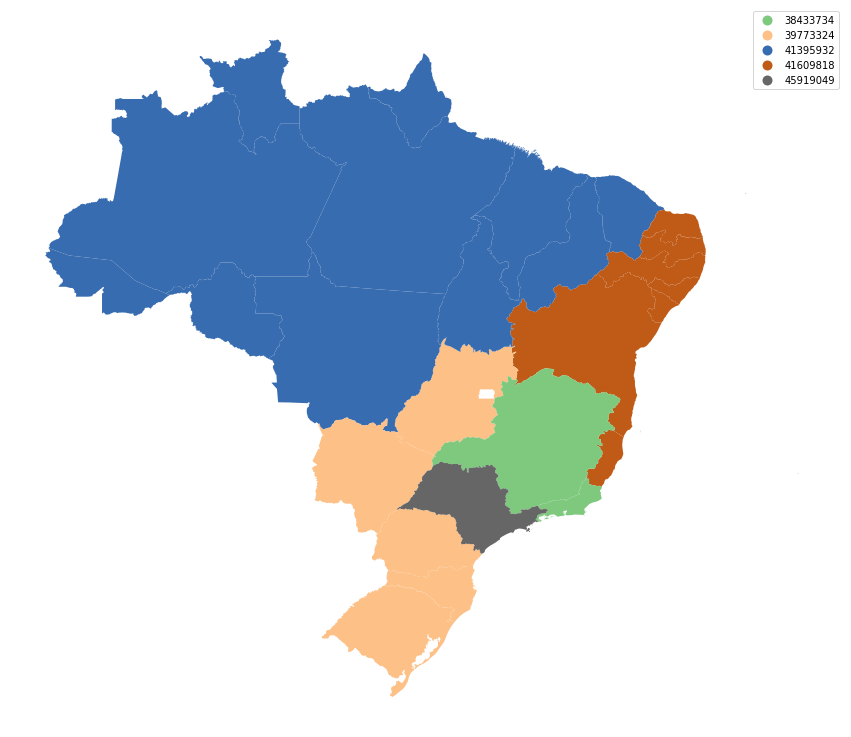

In [228]:
cols = get_colors_regions(m2, 5)
pops = get_pop(cols, vals_est)
text = [str(pops[x]) for x in cols]
plot_map(gdf_est, text)